In [169]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import copy

In [135]:
def edge_detection(image_location):
    # Read the original image
    img = cv2.imread(image_location)
    # img = img[500:950,100:250]
    img = img[500:1450, 100:1000]

    # Convert to graycsale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 

    # Canny Edge Detection
    # edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
    edges = cv2.Canny(image=img_blur, threshold1=200, threshold2=300) # Canny Edge Detection
    return edges

In [263]:
def shape_classifier(blob):
    # based on ratio of height and width
    x_min = 10000000
    x_max = 0
    y_min = 10000000
    y_max = 0
    
    for coor in blob:
        x_min = min([x_min, coor[0]])
        x_max = max([x_max, coor[0]])
        y_min = min([y_min, coor[1]])
        y_max = max([y_max, coor[1]])
        
    height = x_max - x_min
    width = y_max - y_min
    center = (int((x_max+x_min)/2), int((y_max+y_min)/2))
    
    bounds = ((x_min, x_max),(y_min, y_max))
    if height/width > 2:
        return 'tube', center, bounds
    else:
        return 'ball', center, bounds

In [274]:
def proximity(c0, c1, r):
    x = abs(c0[0]-c1[0])
    y = abs(c0[1]-c1[1])
    if (x*x)+(y*y) > r*r:
        return False
    else:
        return True

In [261]:
def get_shapes(blobs):
    shape_centers = dict()
    for blob in blobs:
        shape, center, bounds = shape_classifier(blob)
        if shape not in shape_centers:
            shape_centers[shape] = list()
        
        new = True
        for other_center, other_bounds in shape_centers[shape]:
            if proximity(center, other_center, 10):
                new = False
                
        if new:
            shape_centers[shape].append((center, bounds))
        
    return shape_centers

In [198]:
def blob_finder(edge_image):
    blobs = list()
    for x in range(0, len(edge_image)):
        for y in range(0, len(edge_image[x])):
            if edge_image[x,y] == 255:
                blob, edge_image = find_line(x, y, [(x,y)], edge_image)
                blobs.append(blob)
    return blobs
            
def find_line(x, y, history, edge_image):
    x_min = max(0, x-1)
    x_max = min(len(edge_image), x+1)
    y_min = max(0, y-1)
    y_max = min(len(edge_image[0]), y+1)
    
    for i in range(x_min, x_max+1):
        for j in range(y_min, y_max+1):
            if (i,j) not in history and edge_image[i,j] == 255:
                edge_image[i,j] = 0
                history, edge_image = find_line(i, j, history+[(i,j)], edge_image)
    return history, edge_image

In [ ]:
def find_line(x, y, edge_image):
    line_members = [(x,y)]
    new_members = [(x,y)]
    
    while len(new_members) > 0:
        has_neighbor = False
        
        for pixel in new_members:
            x_min = max(0, pixel[0]-1)
            x_max = min(len(edge_image), pixel[0]+1)
            y_min = max(0, pixel[1]-1)
            y_max = min(len(edge_image[0]), pixel[1]+1)
            
            for i in range(x_min, x_max+1):
                for j in range(y_min, y_max+1):
                    if (i,j) not in line_members and (i,j) not in new_members and edge_image[i,j] == 255:
                        cached_members.append((i,j))
                        has_neighbor = True
                        edge_image[i,j] = 0

            line_members.append(pixel)
        new_members = list()        
        for cm in cached_members:
            new_members.append(cm)


    return line_members, edge_image

In [289]:
def get_colors(shape_dict, image_loc):
    color_dict = dict()

    color_image = cv2.imread(image_loc)
    color_image = color_image[500:1450, 100:1000]

    code = 97
    for ball in shape_dict['ball']:
        ball_coor = ball[0]
        color = (color_image[ball_coor][0], color_image[ball_coor][1], color_image[ball_coor][2])
    #     print(color)
        if color not in color_dict:
            color_dict[color] = chr(code)
            code += 1
    return color_dict

In [296]:
def in_bounds(point, bounds):
    if point[0] >= bounds[0][0] and point[0] <= bounds[0][1]:
        if point[1] >= bounds[1][0] and point[1] <= bounds[1][1]:
            return True
    return False

In [311]:
image_loc = '/Users/tkim/Downloads/bs2.png'

edges = edge_detection(image_loc)
blobs = blob_finder(edges)

full_size_blobs = list()
for blob in blobs:
    if len(blob) > 200:
        full_size_blobs.append(blob)
        
shape_dict = get_shapes(full_size_blobs)

color_dict = get_colors(shape_dict, image_loc)

In [312]:
color_image = cv2.imread(image_loc)
color_image = color_image[500:1450, 100:1000]

tube_dict = dict()

index = 0
for tube in shape_dict['tube']:
#     tube_dict[index] = list()
    tube_dict[index] = str()
    
    tube_bounds = tube[1]
    
    for ball in shape_dict['ball']:
        ball_center = ball[0]
        ball_color = color_dict[(color_image[ball_center][0], color_image[ball_center][1], color_image[ball_center][2])]
        if in_bounds(ball_center, tube_bounds):
#             tube_dict[index].append(ball_color)
            tube_dict[index] = ball_color + tube_dict[index]
    
    index += 1

In [313]:
tube_dict

{0: 'cbaa', 1: 'cbcb', 2: 'acba', 3: '', 4: ''}

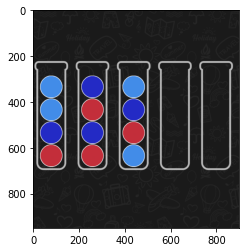

In [317]:
plt.imshow(color_image)

In [316]:
process('/Users/tkim/Downloads/bs2.png')

{0: 'cbaa', 1: 'cbcb', 2: 'acba', 3: '', 4: ''}

In [314]:
def process(image_loc):
    edges = edge_detection(image_loc)
    blobs = blob_finder(edges)

    full_size_blobs = list()
    for blob in blobs:
        if len(blob) > 200:
            full_size_blobs.append(blob)

    shape_dict = get_shapes(full_size_blobs)
    color_dict = get_colors(shape_dict, image_loc)

    color_image = cv2.imread(image_loc)
    color_image = color_image[500:1450, 100:1000]

    tube_dict = dict()
    index = 0
    for tube in shape_dict['tube']:
        tube_dict[index] = str()

        tube_bounds = tube[1]
        for ball in shape_dict['ball']:
            ball_center = ball[0]
            ball_color = color_dict[(color_image[ball_center][0], color_image[ball_center][1], color_image[ball_center][2])]
            if in_bounds(ball_center, tube_bounds):
                tube_dict[index] = ball_color + tube_dict[index]

        index += 1

    return tube_dict